In [1]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..', '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np

from src.LoadEcoCounterData import EcoCounterData as BikeData

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tueplots import bundles
import src.Colortheme as ct
import src.BikeDataPlotter as BikePlotter

# Paper Figure: Counter Correlation Comparison

In [3]:
def reset(daily_bike_data):
    tunnel_df = daily_bike_data[daily_bike_data["counter_site_id"] == 100003358][["iso_timestamp", "zählstand"]]
    steinlach_df = daily_bike_data[daily_bike_data["counter_site_id"] == 100003359][["iso_timestamp", "zählstand"]]
    hirschau_df = daily_bike_data[daily_bike_data["counter_site_id"] == 100026408][["iso_timestamp", "zählstand"]]

    # merge to get data that all counters have in common
    df_data = tunnel_df.merge(steinlach_df, on='iso_timestamp', how='inner', suffixes=('_tunnel', '_steinlach')).merge(hirschau_df, on='iso_timestamp', how='inner')
    df_data.rename(columns={"zählstand": "zählstand_hirschau"}, inplace=True)
    return df_data

def normalize(df_data):
    df_data['zählstand_tunnel'] = df_data['zählstand_tunnel'] / df_data['zählstand_tunnel'].max()
    df_data['zählstand_steinlach'] = df_data['zählstand_steinlach'] / df_data['zählstand_steinlach'].max()
    df_data['zählstand_hirschau'] = df_data['zählstand_hirschau'] / df_data['zählstand_hirschau'].max()
    return df_data

In [ ]:
bd = BikeData()
daily_bike_data = bd.get_daily_data()
df_data = reset(daily_bike_data)

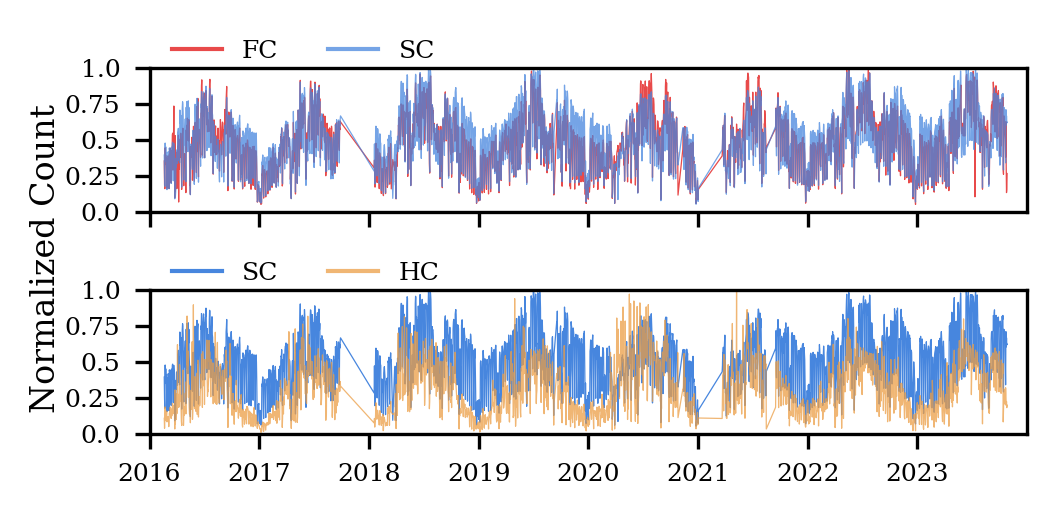

In [5]:
df_data_normalized = normalize(df_data)
trimmed_comp_pairs =    [['zählstand_tunnel', 'zählstand_steinlach'], ['zählstand_steinlach', 'zählstand_hirschau']]
labels =                [["FC","SC"], ["SC","HC"]]
color_mapping = {
    "FC":   0,
    "SC":   1,
    "HC":   2,
}

plt.rcParams.update({"figure.dpi": 300})
with plt.rc_context(bundles.icml2022(column="half", family="serif", usetex=False, nrows=.8, ncols=1)):
    plt.rcParams['font.serif'] = "Times New Roman"
    fig, ax = plt.subplots(2, 1, sharex=True)
    alph = 0.75
    linew = 0.3
    for idx, pair in enumerate(trimmed_comp_pairs):
        ax[idx].plot(
            df_data_normalized["iso_timestamp"],
            df_data_normalized[pair[0]],
            label=labels[idx][0],
            color= BikePlotter.COUNTER[BikePlotter.COUNTER_ORDER[color_mapping[labels[idx][0]]]]["color"],
            alpha=1,
            linewidth=linew,
        )
        ax[idx].plot(
            df_data_normalized["iso_timestamp"],
            df_data_normalized[pair[1]],
            label=labels[idx][1],
            color=BikePlotter.COUNTER[BikePlotter.COUNTER_ORDER[color_mapping[labels[idx][1]]]]["color"],
            alpha=alph,
            linewidth=linew,
        )
        # ax[idx].legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)
        # ax[idx].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
        leg = ax[idx].legend(bbox_to_anchor=(0,1.35), ncol=2, loc="upper left", frameon=False)
        for legobj in leg.legend_handles:
            legobj.set_linewidth(1.0)
        ax[idx].set_ylim(0, 1)
        
        # ax[idx].set_title(f"Daily Average Count Comparison of {pair[0]} and {pair[1]}", loc=BikePlotter.AXIS_TITLE_PARAMS["loc"])
        # ax[idx].set_title(f"{labels[idx]}", loc=BikePlotter.AXIS_TITLE_PARAMS["loc"])
        ax[idx].set_xlim([pd.Timestamp("2016-01-01"), pd.Timestamp("2023-12-31")])
        # ax[idx].set_yticks()
        l = np.arange(0, 1.25, 0.25)
        ax[idx].set(yticks=l, yticklabels=l)
        # ax[idx].grid(lw=0.3, ls=":")
    # ax[-1].set_xlabel('Date')
    # ax[1].set_ylabel('Normalized Count')
    # fig.text(0.5, -0.02, 'Days', ha='center')
    fig.text(-0.035, 0.5, 'Normalized Count', va='center', rotation='vertical')
    # plt.show()
    plt.savefig("fig_counter_comparison_correlation.pdf")